In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

In [21]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [23]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

In [24]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [25]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

In [27]:
from sklearn.metrics import precision_recall_curve

In [28]:
classifier_GB = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(max_depth=7, random_state=42)),
])


#запустим кросс-валидацию
cv_scores_GB = cross_val_score(classifier_GB, X_train, y_train, cv=6, scoring='roc_auc')
cv_score_GB = np.mean(cv_scores_GB)
cv_score_std_GB = np.std(cv_scores_GB)
print('CV score is {}+-{}'.format(cv_score_GB, cv_score_std_GB))

#обучим пайплайн на всем тренировочном датасете
classifier_GB.fit(X_train, y_train)
y_score_GB = classifier_GB.predict_proba(X_test)[:, 1]

CV score is 0.7992293488410116+-0.0038146085909532396


In [29]:
def metrics_models(y_test, y_score): 
    b=1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                    fscore[ix],
                                                                    precision[ix],
                                                                    recall[ix]))
    return thresholds[ix], fscore[ix], precision[ix], recall[ix]

In [30]:
thresholds_GB, fscore_GB, precision_GB, recall_GB = metrics_models(y_test, y_score_GB)

Best Threshold=0.354076, F-Score=0.738, Precision=0.667, Recall=0.826


In [31]:
GB_parameters = [thresholds_GB, fscore_GB, precision_GB, recall_GB]

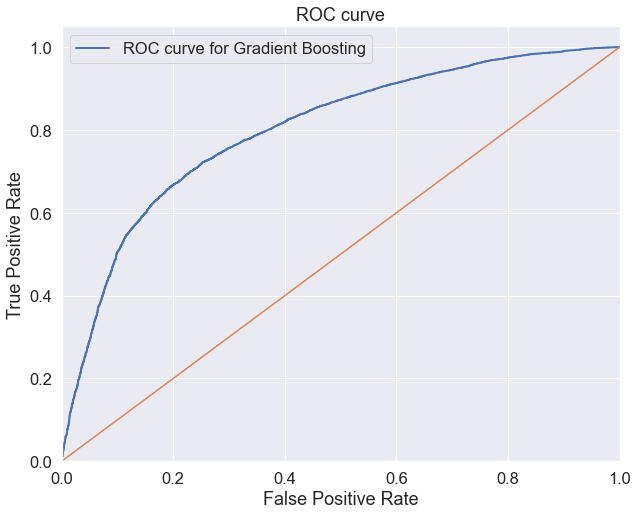

In [40]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, y_score_GB, pos_label=1)
lw = 2

plt.plot(fpr_gb, tpr_gb, lw=lw, label='ROC curve for Gradient Boosting')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.savefig("ROC.png")
plt.show()

In [42]:
from sklearn.metrics import roc_auc_score

#Ваш код здесь
print("roc auc score for Gradient Boosting: {}".format(roc_auc_score(y_test, y_score_GB)))

roc auc score for Gradient Boosting: 0.7994782033397076


In [54]:
roc_auc_gb = roc_auc_score(y_test, y_score_GB)

In [55]:
GB_parameters = [thresholds_GB, fscore_GB, precision_GB, recall_GB, roc_auc_gb]

In [59]:
GB_parameters 

[0.3540755173648278,
 0.7377901291750296,
 0.6667286764021951,
 0.8258064516129032,
 0.7994782033397076]

In [60]:
result = pd.DataFrame(index = ['threshold', 'fscore', 'precision', 'recall', 'roc_auc'], 
                      columns = ['gb_classifier'])

In [61]:
result['gb_classifier'] = GB_parameters 

In [65]:
result.head()

,gb_classifier
threshold,0.354076
fscore,0.737790
precision,0.666729
recall,0.825806
roc_auc,0.799478


In [67]:
result.to_csv('gb_data_classifier', index=False)